### Test pyro model with simulations

In [1]:
# TO REMOVE when notebook is stable

%load_ext autoreload
%autoreload 2

In [2]:
import pyro.distributions as dist
from pyro.distributions.torch_distribution import TorchDistribution
from tissue_purifier.genex.pyro_model_from_scratch import *
from tissue_purifier.genex.gene_utils import *

import numpy
import numpy as np
import torch
import seaborn
import tarfile
import os
import matplotlib
import matplotlib.pyplot as plt
from anndata import read_h5ad
import scanpy as sc
import pandas as pd

from torch.distributions.poisson import Poisson 


/home/jupyter/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# rng = torch.Generator()
# seed = 142
# rng.manual_seed(seed)
# torch.randn((5,2), generator=rng)
# x = torch.random.get_rng_state()

In [4]:
# torch.randn((5,2), generator=rng)
# y = torch.random.get_rng_state()
# print(sum(x != y))

In [5]:
## set parameters for simulation

k = 5
n = 1000 * k
g = 10
nUmis = 10000
l = k


use_covariates_generate = True

simulate_covar = "ncv"
covar_var = 1

In [6]:
## simulate fake ncv/covariate counts

beta0_k1g = dist.Normal(-2, 1).sample((k,g))[:, None, :]

## normalize beta0s so they add up to 1 for each cell-type across all genes **?
## logsumexp to renormalize
beta0_k1g_norm = beta0_k1g - torch.logsumexp(beta0_k1g, dim=-1, keepdim=True)

total_umi_n1 = torch.tensor(nUmis).expand((n,1)).float()
total_umi_n11 = total_umi_n1[..., None]


# sample fake ncv vectors
prob = np.array([0.75])
covar_n1l = dist.Dirichlet(torch.tensor(np.repeat(prob,[l]))).sample((n,1))
#ncv_n1l = torch.ones((n,1,l))

#print(ncv_n1l)
covar_nl = torch.squeeze(covar_n1l, 1)
covar_nl1 = covar_nl.unsqueeze(dim=-1)

## sample fake covariates
beta_klg = dist.Normal(0,covar_var).sample((k,l,g))

## mean centering beta ##
#mean = torch.mean(beta_klg, dim=-2)
#mean = einops.repeat(mean, 'k g -> k l g', l=l)
#beta_klg = beta_klg - mean

#beta_klg = 2*torch.ones((k,l,g))
#beta_klg = beta_klg - torch.mean(beta_klg, dim=-2)
## add in sparsity + regularization later


cell_ids_n = (torch.rand((n))*k).int().long() ##randint instead
#beta0_n1g = beta0_k1g_norm[cell_ids_n]
beta0_n1g = beta0_k1g[cell_ids_n]
beta_nlg = beta_klg[cell_ids_n]

#print(beta_klg)
#print(torch.sum(ncv_nl1 * beta_nlg, dim=-2, keepdim=True))

if use_covariates_generate:
    log_mu_n1g = beta0_n1g + torch.sum(covar_nl1 * beta_nlg, dim=-2, keepdim=True)
    #log_mu_n1g = torch.sum(ncv_nl1 * beta_nlg, dim=-2, keepdim=True)
else:
    log_mu_n1g = beta0_n1g

log_mu_n1g_norm = log_mu_n1g - torch.logsumexp(log_mu_n1g, dim=-1, keepdim=True) ## normalize across genes so that sum of umis is roughly correct
#log_mu_n1g_norm = log_mu_n1g
sim_counts_n1g = Poisson(rate=total_umi_n11*log_mu_n1g_norm.exp()).sample()



In [7]:
# ## simulate fake ssl model counts
# if simulate_covar == "barlow":

#     ## simulate fake barlow counts

#     beta0_k1g = dist.Normal(-2, 1).sample((k,g))[:, None, :]

#     ## normalize beta0s so they add up to 1 for each cell-type across all genes **?
#     ## logsumexp to renormalize
#     beta0_k1g_norm = beta0_k1g - torch.logsumexp(beta0_k1g, dim=-1, keepdim=True)

#     total_umi_n1 = torch.tensor(nUmis).expand((n,1)).float()
#     total_umi_n11 = total_umi_n1[..., None]


#     # sample fake barlow covariates from a Normal(0, 2) distribution, where we change var to test whether the priors are working correctly (optionally add sparsity effect)
#     covar_n1l = dist.Normal(0,2).sample((n,1,l))

#     covar_nl = torch.squeeze(covar_n1l, 1)
#     covar_nl1 = covar_nl.unsqueeze(dim=-1)

#     ## sample fake covariates
#     beta_klg = dist.Normal(0,barlow_var).sample((k,l,g))

#     ## mean centering beta ##
#     #mean = torch.mean(beta_klg, dim=-2)
#     #mean = einops.repeat(mean, 'k g -> k l g', l=l)
#     #beta_klg = beta_klg - mean

#     #beta_klg = 2*torch.ones((k,l,g))
#     #beta_klg = beta_klg - torch.mean(beta_klg, dim=-2)
#     ## add in sparsity + regularization later


#     cell_ids_n = (torch.rand((n))*k).int().long() ##randint instead
#     #beta0_n1g = beta0_k1g_norm[cell_ids_n]
#     beta0_n1g = beta0_k1g[cell_ids_n]
#     beta_nlg = beta_klg[cell_ids_n]

#     #print(beta_klg)

#     if use_covariates_generate:
#         log_mu_n1g = beta0_n1g + torch.sum(covar_nl1 * beta_nlg, dim=-2, keepdim=True)
#     else:
#         log_mu_n1g = beta0_n1g

#     log_mu_n1g_norm = log_mu_n1g - torch.logsumexp(log_mu_n1g, dim=-1, keepdim=True) ## normalize across genes so that sum of umis is roughly correct
#     #log_mu_n1g_norm = log_mu_n1g
#     sim_counts_n1g = Poisson(rate=total_umi_n11*log_mu_n1g_norm.exp()).sample()



In [8]:
print(sim_counts_n1g.shape)
print(torch.mean(sim_counts_n1g.sum(dim=-1)))
print(beta0_k1g.shape)
print(beta0_n1g.shape)

torch.Size([5000, 1, 10])
tensor(9999.8070, dtype=torch.float64)
torch.Size([5, 1, 10])
torch.Size([5000, 1, 10])


### Fit model

In [9]:
use_covariates_model = True

In [10]:
## look for indexing bugs 

## Create GeneDataset

import anndata
from scipy import sparse

    
counts_ng = np.float32(sim_counts_n1g.squeeze()) ## assume n and g aren't 1
sim_anndata = anndata.AnnData(X=sparse.csr_matrix(counts_ng))
sim_anndata.obs['cell_type'] = cell_ids_n.numpy()

sim_anndata.obsm[simulate_covar] = np.array(covar_nl)

## Run GLM

gene_dataset = make_gene_dataset_from_anndata(
        anndata=sim_anndata,
        cell_type_key='cell_type',
        covariate_key = simulate_covar,
        preprocess_strategy='raw',
        apply_pca=False)


In [11]:
assert(np.all(np.array(gene_dataset.cell_type_ids) == cell_ids_n.numpy()))

[iter 0]  loss: 285717024.0000
[iter 500]  loss: 9600776.0000
[iter 1000]  loss: 2534812.0000
[iter 1500]  loss: 1106190.7500
[iter 2000]  loss: 640657.2500
[iter 2500]  loss: 465855.4688
[iter 3000]  loss: 375293.8750
[iter 3500]  loss: 341709.3750
[iter 4000]  loss: 316136.5625
[iter 4500]  loss: 312885.5000
[iter 5000]  loss: 308961.0938
Training completed in 24.367343425750732 seconds


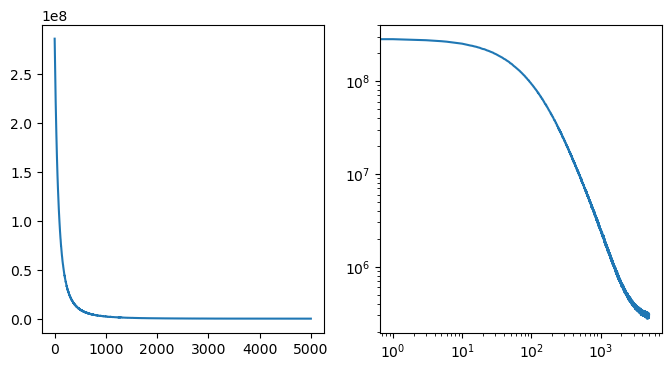

In [12]:
train_dataset, test_dataset, val_dataset = next(iter(train_test_val_split(gene_dataset, random_state=0, train_size=0.8,test_size=0.1,val_size=0.1)))

pyro.clear_param_store()
torch.cuda.empty_cache()

### is this bad to do?
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
gr_cov = GeneRegression(use_covariates = use_covariates_model)
gr_cov.configure_optimizer(optimizer_type='adam', lr=5e-3)

if simulate_covar == 'ncv':
    beta0_k1g_store, beta_klg_store = gr_cov.train(
        dataset=train_dataset,
        n_steps=5000,
        print_frequency=500,
        #l2_regularization_strength=1000,
        subsample_size_cells=1000)
elif simulate_covar == 'barlow':
    beta0_k1g_store, beta_klg_store = gr_cov.train(
        dataset=train_dataset,
        n_steps=5000,
        print_frequency=500,
        l2_regularization_strength=1/barlow_var,
        subsample_size_cells=1000)


fig, axes = plt.subplots(ncols=2, figsize=(8,4))
gr_cov.show_loss(ax=axes[0])
gr_cov.show_loss(ax=axes[1], logy=True, logx=True)

In [13]:
import pyro.poutine as poutine

trace = poutine.trace(gr_cov._model).get_trace(n_cells= n,
           l_cov= l,
           g_genes= g,
           k_cell_types= k,
           use_covariates= use_covariates_model,
           counts_ng= gene_dataset.counts,
           total_umi_n= gene_dataset.counts.sum(dim=-1),
           covariates_nl= gene_dataset.covariates,
           cell_type_ids_n= gene_dataset.cell_type_ids,
           l1_regularization_strength=None,
           l2_regularization_strength=None,
           subsample_size_cells=None)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

Trace Shapes:                  
 Param Sites:                  
        beta0 5    1 10        
Sample Sites:                  
   cells dist         |        
        value   5000  |        
     log_prob         |        
beta_cov dist         |  5 5 10
        value         |  5 5 10
     log_prob         |        
  counts dist   5000  | 10     
        value   5000  | 10     
     log_prob   5000  |        


### Evaluate model fit

In [14]:
## Get fit parameters
pred_beta0_k1g = gr_cov._param_dict["beta0"]

tensor(-4.2991, device='cpu')


Text(0.5, 1.0, 'beta0')

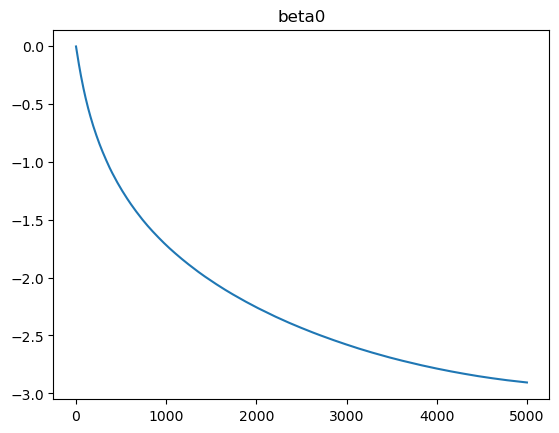

In [15]:
print(beta0_k1g_norm[1, 0, 0])

beta0_inspect = []
for beta0_k1g_temp in beta0_k1g_store:
    beta0_inspect.append(beta0_k1g_temp[1, 0, 0].detach().cpu().numpy())
    
    
plt.plot(beta0_inspect)
plt.title('beta0')

In [16]:
## beta 0 correlation
print("beta0 correlation:")
print(np.corrcoef(beta0_k1g_norm.detach().numpy().flatten(), pred_beta0_k1g.detach().numpy().flatten())[0,1])

beta0 correlation:
0.8948087287699026


In [17]:
# gene_dataset.counts[gene_dataset.cell_type_ids == 0].sum(dim=0)/gene_dataset.counts[gene_dataset.cell_type_ids == 0].sum(dim=0).sum()
# gene_dataset.counts[gene_dataset.cell_type_ids == 1].sum(dim=0)/gene_dataset.counts[gene_dataset.cell_type_ids == 1].sum(dim=0).sum()

Text(0, 0.5, 'predicted parameter value')

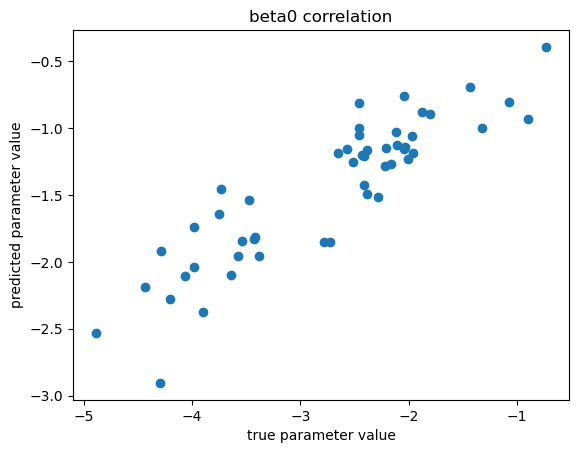

In [18]:
plt.scatter(beta0_k1g_norm.detach().numpy().flatten(), pred_beta0_k1g.detach().numpy().flatten())
plt.title('beta0 correlation')
plt.xlabel('true parameter value')
plt.ylabel('predicted parameter value')

### repeat for beta

In [19]:
## Get fit parameters
pred_beta_klg = gr_cov._param_dict["beta"]

tensor(-2.3868, device='cpu')


Text(0.5, 1.0, 'beta')

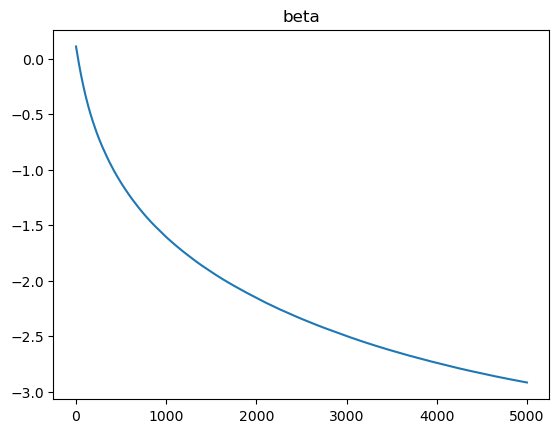

In [20]:
print(beta_klg[1, 0, 0])

beta_inspect = []
for beta_klg_temp in beta_klg_store:
    beta_inspect.append(beta_klg_temp[1, 0, 0].detach().numpy())
    
    
plt.plot(beta_inspect)
plt.title('beta')

In [21]:
## beta correlation
print("beta correlation:")
print(np.corrcoef(beta_klg.detach().numpy().flatten(), pred_beta_klg.detach().numpy().flatten())[0,1])

beta correlation:
0.772405891767156


Text(0, 0.5, 'predicted parameter value')

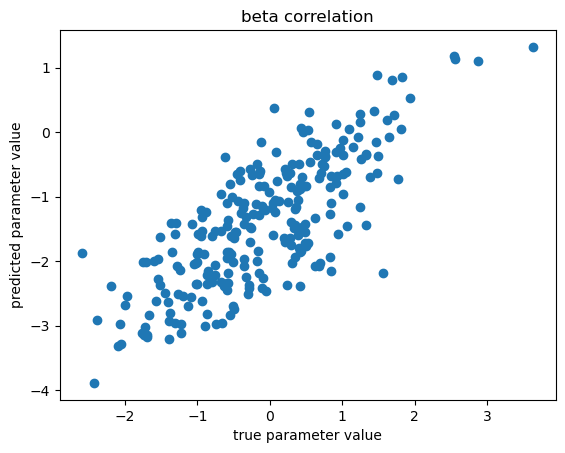

In [22]:
plt.scatter(beta_klg.detach().numpy().flatten(), pred_beta_klg.detach().numpy().flatten())
plt.title('beta correlation')
plt.xlabel('true parameter value')
plt.ylabel('predicted parameter value')

### compare model prediction to true values

Text(0, 0.5, 'predicted counts')

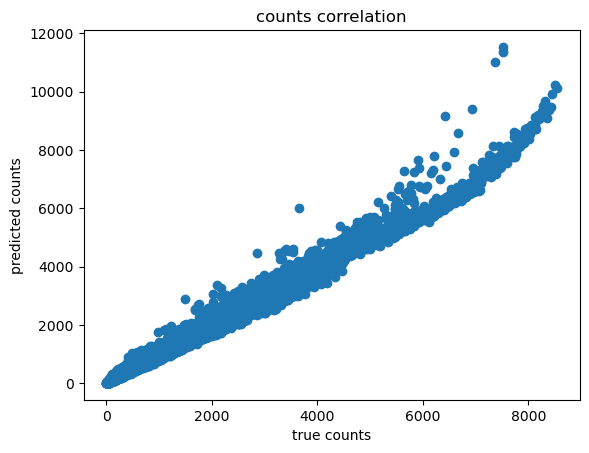

In [23]:
pred_counts_ng, q_ng = gr_cov.predict(train_dataset, 
                         num_samples = 10)

plt.scatter(train_dataset.counts.flatten(), pred_counts_ng.detach().numpy().flatten())
plt.title('counts correlation')
plt.xlabel('true counts')
plt.ylabel('predicted counts')

In [24]:
print("counts correlation:")
print(np.corrcoef(train_dataset.counts.flatten(), pred_counts_ng.detach().numpy().flatten())[0,1])

counts correlation:
0.9948363022868126


Text(0, 0.5, 'predicted counts')

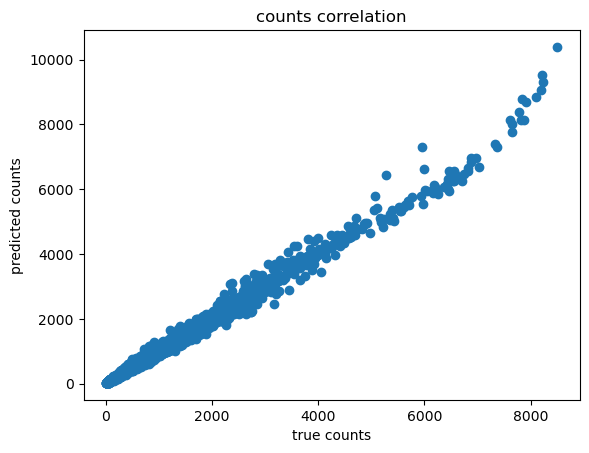

In [25]:
## predict on val dataset 

pred_val_counts_ng, q_val_ng = gr_cov.predict(val_dataset, 
                         num_samples = 10)

plt.scatter(val_dataset.counts.flatten(), pred_val_counts_ng.detach().numpy().flatten())
plt.title('counts correlation')
plt.xlabel('true counts')
plt.ylabel('predicted counts')

In [26]:
print("counts correlation:")
print(np.corrcoef(val_dataset.counts.flatten(), pred_val_counts_ng.detach().numpy().flatten())[0,1])

counts correlation:
0.9953821339373675


### Train baseline model without covariates

[iter 0]  loss: 286027648.0000
[iter 500]  loss: 31774706.0000
[iter 1000]  loss: 10453252.0000
[iter 1500]  loss: 6150253.0000
[iter 2000]  loss: 4311757.0000
[iter 2500]  loss: 3889374.7500
[iter 3000]  loss: 3798995.0000
[iter 3500]  loss: 3508067.2500
[iter 4000]  loss: 3375571.0000
[iter 4500]  loss: 3526076.0000
[iter 5000]  loss: 3444126.5000
Training completed in 13.075057983398438 seconds


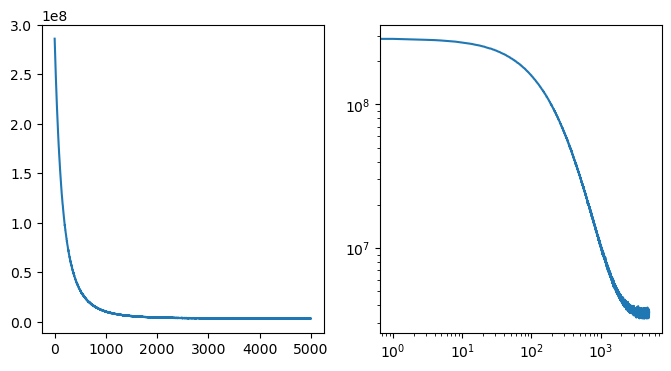

In [27]:
pyro.clear_param_store()
torch.cuda.empty_cache()
gr_baseline = GeneRegression(use_covariates = False)
gr_baseline.configure_optimizer(optimizer_type='adam', lr=5e-3)
beta0_k1g_store, beta_klg_store = gr_baseline.train(
    dataset=train_dataset,
    n_steps=5000,
    use_covariates = False,
    print_frequency=500,
    subsample_size_cells=1000)

fig, axes = plt.subplots(ncols=2, figsize=(8,4))
gr_baseline.show_loss(ax=axes[0])
gr_baseline.show_loss(ax=axes[1], logy=True, logx=True)

q_no_cov_mean:
tensor([[  34.9000,  198.2000,  227.5000,  ...,  130.2000,  429.6000,
         1410.0000],
        [  93.6000,  226.3000,   76.8000,  ...,   69.5000,  287.4000,
          695.4000],
        [  30.0000,   42.8000,   59.4000,  ...,   54.9000,   14.7000,
          379.0000],
        ...,
        [ 345.0000,  322.3000,  268.1000,  ..., 1265.5000,  132.5000,
           26.2000],
        [  77.3000,  125.2000,  181.0000,  ...,  356.2000,  484.2000,
          969.3000],
        [ 306.4000,  592.8000,  189.9000,  ...,  449.1000,  831.2000,
          793.5000]], device='cpu')


Text(0, 0.5, 'predicted counts')

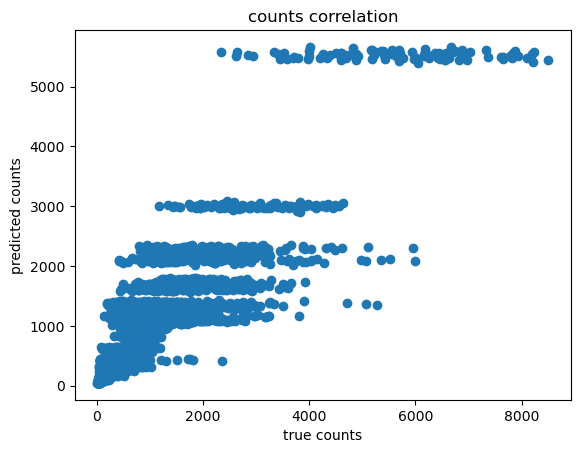

In [28]:
## predict on val dataset 

pred_no_cov_val_counts_ng, q_no_cov_val_ng = gr_baseline.predict(val_dataset, 
                         num_samples = 10)

print("q_no_cov_mean:")
print(q_no_cov_val_ng)

plt.scatter(val_dataset.counts.flatten(), pred_no_cov_val_counts_ng.detach().numpy().flatten())
plt.title('counts correlation')
plt.xlabel('true counts')
plt.ylabel('predicted counts')

In [29]:
print("counts correlation:")
print(np.corrcoef(val_dataset.counts.flatten(), pred_no_cov_val_counts_ng.detach().numpy().flatten())[0,1])

counts correlation:
0.8852932895147554


### Compute q-ratio evaluation metric

In [30]:
pred_no_cov_val_counts_ng, q_no_cov_val_ng = gr_baseline.predict(
    train_dataset,
    num_samples=100,
    subsample_size_cells=1000)

df_baseline_test = gr_baseline.compute_eval_metrics(
    test_dataset,
    num_samples=100,
    subsample_size_cells=1000)

df_baseline_test = df_baseline_test.groupby(["cell_type", "gene"]).mean() 

In [31]:
result_dict = dict()

df_metric_tmp_test, q_z_kg_tmp_test = gr_cov.compute_eval_metrics(
        test_dataset,
        num_samples=100,
        subsample_size_cells=1000,
        gr_baseline = gr_baseline)
    
df_tmp_test = df_metric_tmp_test.groupby(["cell_type", "gene"]).mean()
df_tmp_test["q_ratio"] = df_tmp_test["q_dist"] / df_baseline_test["q_dist"]
result_dict["test_gr_cov"] = df_tmp_test["q_ratio"].values 

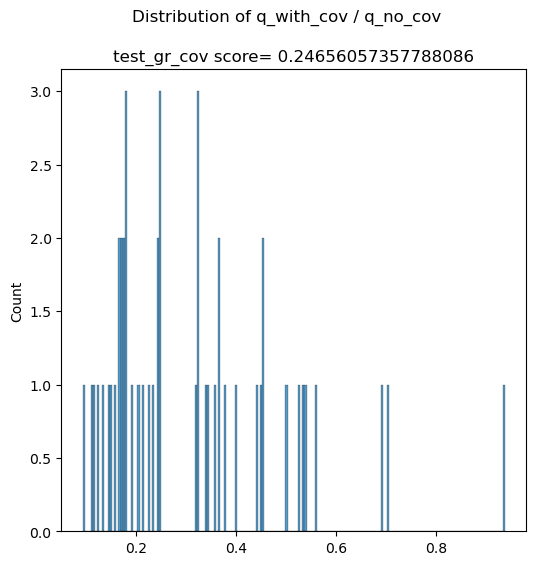

In [32]:
nmax = len(result_dict.keys())
ncols = 1
nrows = int(numpy.ceil(float(nmax)/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 6*nrows))
fig.suptitle("Distribution of q_with_cov / q_no_cov")
    
score_dict = dict()
    
for n, key in enumerate(result_dict.keys()):
    r,c = n//ncols, n%ncols
    #ax_cur = axes[r,c]
    _ = seaborn.histplot(x=result_dict[key], bins=200)
    score = numpy.median(result_dict[key])
    score_dict[key] = score
    _ = axes.set_title("{} score= {}".format(key, score))

### Compute mad z-score evaluation metric

q_z_mean:
tensor(-0.9923, device='cpu')


(array([ 1.,  0.,  3.,  7., 15., 13.,  7.,  2.,  1.,  1.]),
 array([-1.8639183 , -1.6915509 , -1.5191835 , -1.3468161 , -1.1744486 ,
        -1.0020813 , -0.8297138 , -0.6573464 , -0.484979  , -0.31261158,
        -0.14024417], dtype=float32),
 <BarContainer object of 10 artists>)

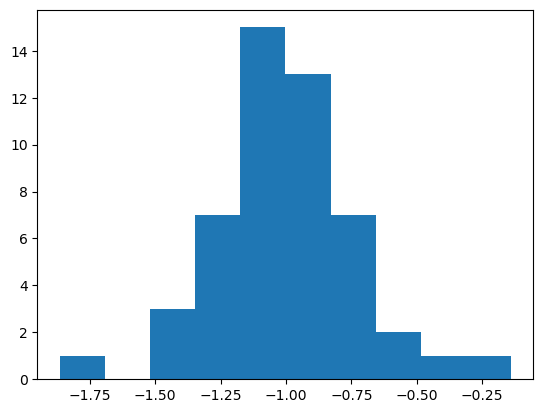

In [33]:
## predict on val dataset 

print('q_z_mean:')
print(q_z_kg_tmp_test.mean())

plt.hist(q_z_kg_tmp_test.flatten())
# plt.scatter(val_dataset.counts.flatten(), pred_val_counts_ng.detach().numpy().flatten())
# plt.title('counts correlation')
# plt.xlabel('true counts')
# plt.ylabel('predicted counts')

### Test get parameters method

gr cov:
     beta_1    beta_2    beta_3    beta_4    beta_5    beta_0 cell_type gene
0 -1.477544 -2.367186 -1.608684 -1.579111 -2.015765 -1.851315         0    0
1 -1.427800 -3.310014 -1.447953 -0.636108 -2.035309 -1.827861         0    1
2  1.103507 -2.353029 -0.680705 -2.983468 -0.502971 -1.155090         0    2
3 -1.236997 -0.693639 -1.176902 -1.098028 -0.603101 -1.025688         0    3
4 -1.643136 -0.850783  0.050936 -0.834195 -0.362093 -0.811362         0    4
gr baseline:
     beta_0 cell_type gene
0 -3.644796         0    0
1 -3.515471         0    1
2 -2.003090         0    2
3 -1.986984         0    3
4 -1.519128         0    4


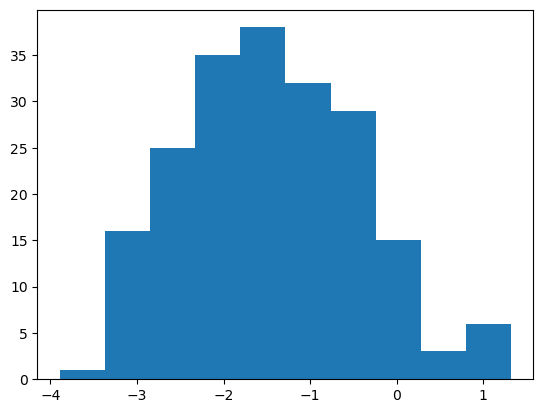

In [34]:
print("gr cov:")
param_df = gr_cov.get_params()
print(param_df.head())

plt.hist(np.array(param_df.iloc[:,:(l-1)]).flatten())

print("gr baseline:")
param_baseline_df = gr_baseline.get_params()
print(param_baseline_df.head())